# 5章 誤差逆伝播法

180226, pp123-163

目次

1. 計算グラフ
2. 連鎖律
3. 逆伝播
4. 単純なレイヤの実装
5. 活性化関数レイヤの実装
6. Affine/Softmaxレイヤの実装
7. 誤差逆伝播法の実装


## 概要

4章では、ニューラルネットワークの重みパラメータの勾配（重みパラメータに関する損失関数の勾配）は、数値微分によって求めた。数値微分はシンプルで実装は簡単だが、計算に時間がかかる。本章では、重みパラメー タの勾配の計算を効率良く行う手法である「誤差逆伝播法」について学ぶ。

誤差逆伝播法を正しく理解する方法
1. 数式; 厳密で簡潔になるが、本質的なことを見逃したり数式の羅列にとどまることがある。
2. 計算グラフ; 視覚的に説明し、「なるほど!」と納得できるため、本章では計算グラフの説明を行う。

重要：　誤差逆伝播法の概念、レイヤによる実装

## 1 計算グラフ
計算の過程をグラフによって表現。順伝播（左→右）と逆伝播（右→左）。**逆伝播によって微分を効率よく計算**できる。

## 2. 連鎖律
ある関数が合成関数で表される場合、その合成関数の微分は、合成関数を構成するそれぞれの関数の微分の積によって表すことができる。

## 3. 逆伝播
加算ノード： そのまま伝播　（インプットを保存する必要なし）。 z = x + y の偏微分は共に1なため。

乗算ノード： ひっくり返した値を乗算し伝播（インプットを保持）　z = xy の偏微分はひっくり返るため。


### 前準備

In [1]:
# この後必要になるライブラリを一括でDL
import numpy as np
import sys, os, time
from collections import OrderedDict # 順序付きDict
import matplotlib.pyplot as plt

sys.path.append(os.pardir) # load_mnistするために親ディレクトリを追加。必要に応じて変更 or dataset.mnistを別途import
from dataset.mnist import load_mnist

In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [3]:
## これまでの章で使った関数のインポート。 
## 本来は下記の2つのインポート文でも良いが、参照しやすいように記載
# from common.layers import *
# from common.gradient import numerical_gradient

# 3.2 章
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

# 4.4章より, 微分を使った勾配算出用 
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

# 3章より
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

# 4章より
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

## 4. 単純なレイヤの実装　（乗算と加算レイヤ）
実際にニューラルネットワークを構築するときに、それぞれのレイヤを組み合わせるだけで簡単に計算できるようになる。（ここではデモのみ）

乗算レイヤーの実装

In [4]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    # 順伝播
    def forward(self, x, y):
        self.x = x
        self.y = y                
        out = x * y

        return out

    # 逆伝播
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x

        return dx, dy

乗算レイヤを実施に使ってみる。2つのリンゴを購入して消費税1.1が掛かった場合。

In [5]:
# 100円のリンゴ2つを購入し、1.1倍する。
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

print("dapple * apple = " + ('%0.0f' % (dapple * apple)) )
print("dapple_num * apple_num = " + ('%0.0f' % (dapple_num * apple_num)))
print("dTax * tax = " + ('%0.0f' % (dtax * tax)) )

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200
dapple * apple = 220
dapple_num * apple_num = 220
dTax * tax = 220



加算レイヤの実装

In [6]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

加算レイヤを乗算レイヤと組み合わせて実際に使ってみる。リンゴ2個とみかん3個を購入し、消費税1.1が掛かった場合。

In [7]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## 5. 活性化関数レイヤの実装
ReLU と Sigmoidの実装。Sigmoidの逆伝播は143-146参照。

In [8]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0 # x <= 0で0を出力

        return out

    def backward(self, dout):
        dout[self.mask] = 0 # x <= 0で0を出力
        dx = dout

        return dx


In [9]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

## 6. Affine/Softmaxレイヤの実装
入力である行列に重さを乗算し、バイアスを加える。(Y=XW+B)

Affine: 行列の積の計算を、幾何学の分野では「アフィン変換」という。


入力（X）への逆伝播： ∂L/∂X = ∂L/∂Y ・ W.T

重み（W）への逆伝播：∂L/∂W = X.T ・ ∂L/∂Y

バイアス（B）への逆伝播：∂L/∂B = ∂L/∂Yの列方向に対する和

In [10]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

ここではSoftmaxと交差エントロピー誤差をまとめて実装している。そうすることで、逆伝播の値がy-tという非常にキレイな値となる。

Softmaxには交差エントロピー誤差を、恒等関数の場合は二乗和誤差を損失関数として求めると、キレイな結果となる。

In [11]:
#Softmaxと交差 エントロピー誤差をまとめて実装。
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

**具体例1**： Softmaxレイヤの出力（0.3, 0.2, 0.5）で教師ラベルが（0, 1, 0）の場合

正解の確率が20%しかない。y-tが（0.3, -0.8, 0.5）と大きい値となり、大きな誤差が逆伝播される。

**具体例2**： Softmaxレイヤの出力（0.01, 0.99, 0）で教師ラベルが（0, 1, 0）の場合

正解の確率が99%。y-tが（0.01, -0.01, 0）となり、小さい誤差が逆伝播される。

## 7. 誤差逆伝播法の実装
これまでのレイヤを組み合わせることで、まるでレゴブロックのようにニューラルネットワークを実装することができる。

In [12]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


In [13]:
# 実行速度の差を確認する用
import time
class Timer:
    def __init__(self):
        self.start = time.time()
        self.lap_start = self.start
        self.lap_list = []

    def lap_show (self):
        now = time.time()
        lap = now - self.lap_start
        self.lap_list.append(lap)
        self.lap_start = now
        print("lap " + str(len(self.lap_list)) + ((": %0.7f sec") %lap) )

In [14]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

timer = Timer()
print("実行速度 lap1: 数値微分、lap2: 誤差逆伝播法")

grad_numerical = network.numerical_gradient(x_batch, t_batch) # 数値微分
timer.lap_show()

grad_backprop = network.gradient(x_batch, t_batch)
timer.lap_show()

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

print(("誤差逆伝播法の方が%0.1f倍早い" % (timer.lap_list[0] / timer.lap_list[1])))

実行速度 lap1: 数値微分、lap2: 誤差逆伝播法
lap 1: 17.7218502 sec
lap 2: 0.0016599 sec
W1:4.19503097552e-10
b2:1.39655118951e-07
W2:5.16147253303e-09
b1:2.7570582356e-09
誤差逆伝播法の方が10676.6倍早い


一応ここで何が起きているのか確認（時間があれば）

x_train.shape:(60000, 784)
t_train.shape:(60000, 10)
x_train[0]の画像。28×28 = 784


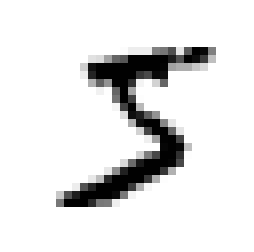

In [15]:
print("x_train.shape:" + str(x_train.shape))
print("t_train.shape:" + str(t_train.shape))
print("x_train[0]の画像。28×28 = 784")

# 画像の表示
import matplotlib
%matplotlib inline
some_digit = x_train[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [16]:
print("x_batch: " + str(x_batch.shape))
print("W1: " + str(network.params['W1'].shape))
print("b1: " + str(network.params['b1'].shape))
print("W2: " + str(network.params['W2'].shape))
print("b2: " + str(network.params['b2'].shape))

x_batch: (3, 784)
W1: (784, 50)
b1: (50,)
W2: (50, 10)
b2: (10,)


In [17]:
print("x_batch: " + str(x_batch.shape))
print("Affine1の結果: X (3,784) * W (784, 50) + b1(50,) = (3, 50)")
res1 = network.layers['Affine1'].forward(x_batch)
print("After affine1: " + str(res1.shape))
print(res1[0])
print("")

print("ReLU1の結果： (3, 50)の中でx<0を0に置換")
res2 = network.layers['Relu1'].forward(res1)
print("After ReLU: " + str(res2.shape))
print(res2[0])
print("")

print("Affine2の結果: X (3,50) * W2 (50, 10) + b2(10,) = (3, 10)")
res3 = network.layers['Affine2'].forward(res2)
print("After affine2: " + str(res3.shape))
print(res3[0])
print("")

print("softmax, 確率に変換")
res4 = softmax(res3)
print(res4[0])
print("1つのサンプルにつき総和は" + str(np.sum(res4[0])))
print("")

res5 = cross_entropy_error(res4, t_batch)
print("交差エントロピー誤差：" + str(res5))

x_batch: (3, 784)
Affine1の結果: X (3,784) * W (784, 50) + b1(50,) = (3, 50)
After affine1: (3, 50)
[-0.03346961 -0.02209822  0.09428647  0.07258174 -0.00075832  0.04128724
  0.01685031  0.04622215 -0.09349863  0.16950605  0.21224032 -0.04984727
 -0.07236086  0.03207296  0.03925295 -0.02701086  0.07330976 -0.14762438
 -0.03713037 -0.00277914 -0.08626437  0.04495235  0.04345102 -0.07364867
  0.0255347   0.11300004  0.01206745 -0.01550124  0.12050815 -0.06227472
  0.0123423   0.12186568  0.04213566 -0.13564951 -0.16607256  0.04745166
 -0.07513735  0.02154409 -0.08790411  0.01461395 -0.03221075  0.02541651
 -0.07729277 -0.05064019  0.04622644  0.00264495 -0.14710056  0.02368563
 -0.0868902  -0.12672689]

ReLU1の結果： (3, 50)の中でx<0を0に置換
After ReLU: (3, 50)
[ 0.          0.          0.09428647  0.07258174  0.          0.04128724
  0.01685031  0.04622215  0.          0.16950605  0.21224032  0.          0.
  0.03207296  0.03925295  0.          0.07330976  0.          0.          0.
  0.          0.

上記が1セット。勾配を求めるために数値微分を行う場合、各パラメーターの各値につき±hの交差エントロピー誤差を算出する必要がある。

(W1(784 * 50) + b1(50) + W2(50 * 10) + b2(10))  * 2 = 79520回上記の計算を繰り返して、やっと1回全てのパラメータを更新できる。

In [18]:
(784*50+50+50*10+10)*2

79520

一方、誤差逆伝播法の場合、逆伝播を行っていくだけ。

In [19]:
print("まず一度1セット流して値をセット")
print("loss " + str(network.loss(x_batch, t_batch)))
print("")

print("逆伝播, softmax & cross_entropy_error, 計算内容：y-t")
dout = 1
dout = network.lastLayer.backward(dout)
print(dout.shape)
print(dout[0])
print("")

print("逆伝播, Affine2, 計算内容： 2回内積, 1回総和")
dout = network.layers['Affine2'].backward(dout)
print(dout.shape)
print(dout[0])
print("")

print("逆伝播, ReLU1, 計算内容： x<0の判定、0の代入")
dout = network.layers['Relu1'].backward(dout)
print(dout.shape)
print(dout[0])
print("")

print("逆伝播, Affine2, 計算内容：2回内積, 1回総和")
dout = network.layers['Affine1'].backward(dout)
print(dout.shape)
print("")

print("W1, W2, b1, b2もこれで計算されている")
print("W1" + str(network.layers['Affine1'].dW.shape))
print("W2" + str(network.layers['Affine2'].dW.shape))
print("b1" + str(network.layers['Affine1'].db.shape))
print("b2" + str(network.layers['Affine2'].db.shape))

まず一度1セット流して値をセット
loss 2.30162797276

逆伝播, softmax & cross_entropy_error, 計算内容：y-t
(3, 10)
[ 0.03349971  0.03323064  0.03325989  0.03322101  0.0334467  -0.2999237
  0.03346984  0.03325047  0.03337984  0.03316559]

逆伝播, Affine2, 計算内容： 2回内積, 1回総和
(3, 50)
[  2.19227530e-03   5.24925815e-03  -1.74718373e-04   1.04108396e-05
  -2.00154219e-03  -1.46907545e-03  -6.96940644e-03   4.42597134e-03
  -7.53770142e-03  -2.16003111e-03  -7.72511713e-04  -2.17785675e-03
   1.46818527e-03  -4.99829772e-04   1.77953608e-03  -6.64849473e-03
   2.57168171e-03  -9.56849227e-04  -8.36352133e-04   1.76210897e-03
  -5.73687636e-03  -9.98545451e-06   5.26668354e-03   6.70992290e-03
   5.34164041e-04  -3.20545869e-03  -2.71229881e-03  -1.16327486e-03
   5.76032200e-03  -2.42314604e-03   8.07136820e-04  -5.44532344e-03
  -6.32206901e-05   4.27886241e-04  -8.55563056e-04  -6.87758454e-03
  -4.25330011e-03   2.35374108e-03   8.77283161e-04   2.29986832e-03
  -1.61236361e-03  -3.27186930e-03   1.33737983e-03  -3.24

ほぼほぼ同じ精度を出しているのに、計算回数は数万倍ぐらい違う。計算が1万倍ぐらい早くなるのも当然である。

最後に、一応実装結果を確認してみる。（4章と同一であるため説明省略）

In [20]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

timer = Timer()

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        timer.lap_show()
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


lap 1: 1.3485000 sec
train acc, test acc | 0.0644666666667, 0.059
lap 2: 4.4882171 sec
train acc, test acc | 0.9025, 0.9047
lap 3: 3.3373680 sec
train acc, test acc | 0.9201, 0.9223
lap 4: 3.1633780 sec
train acc, test acc | 0.937366666667, 0.9383
lap 5: 3.1721389 sec
train acc, test acc | 0.947483333333, 0.9481
lap 6: 2.7860980 sec
train acc, test acc | 0.951683333333, 0.9496
lap 7: 3.2809110 sec
train acc, test acc | 0.9584, 0.9569
lap 8: 2.4228640 sec
train acc, test acc | 0.963266666667, 0.9595
lap 9: 3.1045799 sec
train acc, test acc | 0.964533333333, 0.9613
lap 10: 3.7780511 sec
train acc, test acc | 0.969366666667, 0.9641
lap 11: 3.4093261 sec
train acc, test acc | 0.971466666667, 0.9659
lap 12: 2.6490018 sec
train acc, test acc | 0.97265, 0.9671
lap 13: 3.0520132 sec
train acc, test acc | 0.9749, 0.9694
lap 14: 3.1590970 sec
train acc, test acc | 0.97505, 0.968
lap 15: 2.7254748 sec
train acc, test acc | 0.977216666667, 0.9698
lap 16: 3.1717241 sec
train acc, test acc | 0.97868

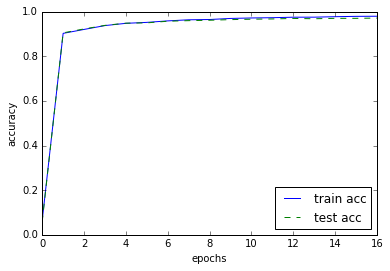

In [21]:
# plot accuracy
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()